<a href="https://colab.research.google.com/github/nguyenquochuy2311/Recommend-Sytem-Amazon/blob/main/Recommender_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mục mới

In [8]:
#Import các thư viện
%matplotlib inline
import numpy as np
import pandas as pd #đọc dữ liệu từ file json
import matplotlib.pyplot as plt
from pandas import DataFrame 
import nltk

from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn import neighbors
from scipy.spatial.distance import cosine
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

import re
import string
from wordcloud import WordCloud, STOPWORDS
from sklearn.metrics import mean_squared_error

In [9]:
#Đọc file json gán vào biến df
df = pd.read_json('data/Beauty_5.json')

In [10]:
#Convert sang file .csv
df.to_csv('data/reviews.csv', sep=',', index=False)

In [ ]:
#In ra các title của cột
print(df.columns)

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime', 'reviewesrName'],
      dtype='object')


In [ ]:
#Thống kê số hàng và số cột
print(df.shape)

(198502, 10)


In [ ]:
#Gom nhóm theo ID sản phẩm là 'asin' và in ra danh sách
count = df.groupby("asin", as_index=False).count()
mean = df.groupby("asin", as_index=False).mean()

dfMerged = pd.merge(df, count, how='right', on=['asin'])
dfMerged

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewesrName_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,reviewesrName_y
0,A1YJEY40YUW4SE,7806397051,Andrea,"[3, 4]",Very oily and creamy. Not at all what I expect...,1,Don't waste your money,1391040000,"01 30, 2014",NaN,8,8,8,8,8,8,8,8,0
1,A60XNB876KYML,7806397051,Jessica H.,"[1, 1]",This palette was a decent price and I was look...,3,OK Palette!,1397779200,"04 18, 2014",NaN,8,8,8,8,8,8,8,8,0
2,A3G6XNM240RMWA,7806397051,Karen,"[0, 1]",The texture of this concealer pallet is fantas...,4,great quality,1378425600,"09 6, 2013",NaN,8,8,8,8,8,8,8,8,0
3,A1PQFP6SAJ6D80,7806397051,Norah,"[2, 2]",I really can't tell what exactly this thing is...,2,Do not work on my face,1386460800,"12 8, 2013",NaN,8,8,8,8,8,8,8,8,0
4,A38FVHZTNQ271F,7806397051,Nova Amor,"[0, 0]","It was a little smaller than I expected, but t...",3,It's okay.,1382140800,"10 19, 2013",NaN,8,8,8,8,8,8,8,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198497,A2BLFCOPSMBOZ9,B00LLPT4HI,Dave Edmiston,"[0, 0]",Just a little dab of this shea butter should b...,5,A little dab...,1405468800,"07 16, 2014",NaN,7,7,7,7,7,7,7,7,0
198498,A1UQBFCERIP7VJ,B00LLPT4HI,Margaret Picky,"[0, 0]",This shea butter is completely raw and unrefin...,5,Pure organic raw shea butter,1405296000,"07 14, 2014",NaN,7,7,7,7,7,7,7,7,0
198499,A35Q0RBM3YNQNF,B00LLPT4HI,M. Hill,"[0, 0]",The skin is the body's largest organ and it ab...,5,One Pound Organic Grade A Unrefined Shea Butter,1405468800,"07 16, 2014",NaN,7,7,7,7,7,7,7,7,0
198500,A3LGT6UZL99IW1,B00LLPT4HI,"Richard C. Drew ""Anaal Nathra/Uthe vas Bethod...","[0, 0]",I have very dry elbows and knees. I have a to...,5,This stuff is amazing!,1405382400,"07 15, 2014",NaN,7,7,7,7,7,7,7,7,0


In [ ]:
#Thay đổi tên các cột
dfMerged["totalReviewers"] = dfMerged["reviewerID_y"]
dfMerged["overallScore"] = dfMerged["overall_x"]
dfMerged["summaryReview"] = dfMerged["summary_x"]

#Gán sang bảng dữ liệu mới với các tên cột mới -> Bảng thống kê các thành phần như: Câu review tóm tắt, điểm tổng, tổng số người viết review đó
dfNew = dfMerged[['asin','summaryReview','overallScore',"totalReviewers"]]

In [ ]:
dfNew

,asin,summaryReview,overallScore,totalReviewers
0,7806397051,Don't waste your money,1,8
1,7806397051,OK Palette!,3,8
2,7806397051,great quality,4,8
3,7806397051,Do not work on my face,2,8
4,7806397051,It's okay.,3,8
...,...,...,...,...
198497,B00LLPT4HI,A little dab...,5,7
198498,B00LLPT4HI,Pure organic raw shea butter,5,7
198499,B00LLPT4HI,One Pound Organic Grade A Unrefined Shea Butter,5,7
198500,B00LLPT4HI,This stuff is amazing!,5,7


In [ ]:
#Chọn các sản phẩm có hơn 100 đánh giá
dfMerged = dfMerged.sort_values(by='totalReviewers', ascending=False)
dfCount = dfMerged[dfMerged.totalReviewers >= 100]
dfCount

,reviewerID_x,asin,reviewerName_x,helpful_x,reviewText_x,overall_x,summary_x,unixReviewTime_x,reviewTime_x,reviewesrName_x,reviewerID_y,reviewerName_y,helpful_y,reviewText_y,overall_y,summary_y,unixReviewTime_y,reviewTime_y,reviewesrName_y,totalReviewers,overallScore,summaryReview
112495,A23NJ9AMXSVC6D,B004OHQR1Q,BerraH,"[0, 0]",My daughter ordered these and they were not wh...,2,Disappointed,1349395200,"10 5, 2012",NaN,431,431,431,431,431,431,431,431,0,431,2,Disappointed
112840,A1BVCXRXX4JLAW,B004OHQR1Q,Tanya B,"[0, 0]",One of the dotters broke when I went to use it...,2,okay,1391040000,"01 30, 2014",NaN,431,431,431,431,431,431,431,431,0,431,2,okay
112581,A1L9ZTGO75717E,B004OHQR1Q,gatorsgate,"[0, 0]",I would recommend these dotting tools to anyon...,5,Dotting 5 X 2 Way Marbleizing Dotting Pen Set,1398124800,"04 22, 2014",NaN,431,431,431,431,431,431,431,431,0,431,5,Dotting 5 X 2 Way Marbleizing Dotting Pen Set
112582,A3DDZQYUAE9WNP,B004OHQR1Q,gee,"[0, 0]",These are easy to use. Gets the job done and c...,5,Love the look.,1375833600,"08 7, 2013",NaN,431,431,431,431,431,431,431,431,0,431,5,Love the look.
112583,AL2ODY4R6992H,B004OHQR1Q,Gen517,"[0, 0]",Variation of dot sizes. Great buy especially f...,5,Great dotting tool,1378425600,"09 6, 2013",NaN,431,431,431,431,431,431,431,431,0,431,5,Great dotting tool
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139467,A2B1QU9EKEEUZ8,B006RFZ66K,Matthew Schenker,"[0, 0]","I got this product for my wife (in her 40's), ...",5,Does what it promises!,1362009600,"02 28, 2013",NaN,100,100,100,100,100,100,100,100,0,100,5,Does what it promises!
168744,A2QDOJFFLFGF18,B00AE078YM,"Mr and Mrs Michael Alexander ""greenacres""","[0, 0]",I did not see any difference in my hair. I fol...,3,Seven Days,1365552000,"04 10, 2013",NaN,100,100,100,100,100,100,100,100,0,100,3,Seven Days
139490,A35IDGYIST7CLI,B006RFZ66K,Sarah,"[0, 0]",I have used these in the past and they have al...,2,Just use facial cleaner,1388188800,"12 28, 2013",NaN,100,100,100,100,100,100,100,100,0,100,2,Just use facial cleaner
86802,A1DQHS7MOVYYYA,B0039UTO3M,A. Boston,"[50, 55]","I'm no drag queen, but I like a full lash. I l...",3,A nice natural look,1275523200,"06 3, 2010",NaN,100,100,100,100,100,100,100,100,0,100,3,A nice natural look


In [ ]:
#Gom nhóm tất cả các bài đánh giá tóm tắt theo ID sản phẩm
dfProductReview = df.groupby("asin", as_index=False).mean()
ProductReviewSummary = dfCount.groupby("asin")["summaryReview"].apply(list)
ProductReviewSummary = pd.DataFrame(ProductReviewSummary)
ProductReviewSummary.to_csv("data/ProductReviewSummary.csv")

In [ ]:
#In ra bảng dữ liệu sau khi gom nhóm
dfProductReview

,asin,overall,unixReviewTime
0,7806397051,2.625000,1.382087e+09
1,9759091062,3.090909,1.390930e+09
2,9788072216,5.000000,1.342552e+09
3,9790790961,4.333333,1.378858e+09
4,9790794231,3.600000,1.298212e+09
...,...,...,...
12097,B00L6Q3BH6,4.400000,1.400734e+09
12098,B00LC EROA2,5.000000,1.404778e+09
12099,B00LCEROA2,5.000000,1.404626e+09
12100,B00LG63DOM,4.800000,1.405823e+09


In [ ]:
#Tạo các bảng dữ liệu với các cột xác định
df3 = pd.read_csv("data/ProductReviewSummary.csv")
df3 = pd.merge(df3, dfProductReview, on="asin", how='inner')

In [ ]:
#Lựa chọn ra các cột
df3 = df3[['asin','summaryReview','overall']]

In [ ]:
##Làm sạch dữ liệu và tổng hợp các cột

In [ ]:
#Hàm mã hoá các tóm tắt (tổng hợp)
regEx = re.compile('[^a-z]+')
def cleanReviews(reviewText):
    reviewText = reviewText.lower()
    reviewText = regEx.sub(' ', reviewText).strip()
    return reviewText

In [ ]:
#Reset các giá trị index và xoá các hàng bị trùng
df3["summaryClean"] = df3["summaryReview"].apply(cleanReviews)
df3 = df3.drop_duplicates(['overall'], keep='last')
df3 = df3.reset_index()

In [ ]:
df3

,index,asin,summaryReview,overall,summaryClean
0,0,B0000530ED,"['Works well with certain types of hair, and i...",4.009709,works well with certain types of hair and if y...
1,1,B0000632EN,"['5 star moisturizer', 'Not good', 'Drying, Ca...",3.802721,star moisturizer not good drying cakey feeling...
2,2,B0000CC64W,"['HOLY TINY TEST TUBE', 'Great stuff!', 'Velve...",4.314685,holy tiny test tube great stuff velvety smooth...
3,3,B000142C1A,"[""I love Essie but I don't love this one..."", ...",4.482456,i love essie but i don t love this one cute ma...
4,4,B000142FVW,"['Nice', 'OPI never disappoints.', 'jade is th...",4.552980,nice opi never disappoints jade is the new bla...
...,...,...,...,...,...
167,169,B00KAL5JAU,"['well worth it', 'Makes My Curls Look Gorgeou...",4.761194,well worth it makes my curls look gorgeous lea...
168,170,B00KCFAZTE,"['Amazing Eye Cream', 'Works Great For My Bags...",4.759259,amazing eye cream works great for my bags fadi...
169,171,B00KHGIK54,"['Effective All Around Moisturizer', 'My new G...",4.832061,effective all around moisturizer my new go to ...
170,172,B00KHH2VOY,"['another fantastic Adovia product', 'Surprise...",4.877049,another fantastic adovia product surprised by ...


In [ ]:
#Lưu dữ liệu cột "summaryClean"
reviews = df3["summaryClean"] 
countVector = CountVectorizer(max_features = 300, stop_words='english') 
transformedReviews = countVector.fit_transform(reviews) 

dfReviews = DataFrame(transformedReviews.A, columns=countVector.get_feature_names())
dfReviews = dfReviews.astype(int)

In [ ]:
dfReviews

,absolutely,acne,actually,adovia,affordable,amazing,application,apply,argan,art,average,away,awesome,axe,bad,bar,base,beautiful,beauty,best,better,big,bit,black,blush,body,bottle,bought,brand,brush,brushes,buy,care,cheap,clay,clean,cleans,cleanser,cleansing,clear,...,summer,sun,sunscreen,super,sure,surprised,tape,texture,thing,think,time,toner,tool,tools,treatment,tried,try,use,used,uses,using,value,variety,ve,vitamin,wash,waste,way,wen,white,wife,wipes,wonderful,work,worked,working,works,worth,wow,yes
0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,4,0,9,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0
1,0,3,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,1,3,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,4,1,1,...,0,0,1,0,3,1,0,0,0,1,2,0,0,0,0,1,0,3,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,3,0,0,3,2,1,2
2,0,0,0,0,0,1,0,0,0,0,2,0,0,0,3,0,0,0,0,6,1,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,4,2,0,0,0,0,2,0,0,0,0,0,0,0,0,3,3,0,0,9,1,0,0
3,0,0,0,0,0,2,0,0,0,0,0,1,2,0,0,0,0,10,0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,2,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,2,0,0,0,0,0,0,2,0,1,0,0,22,0,9,1,1,0,2,0,0,1,1,1,0,0,1,0,0,0,0,0,0,0,0,...,4,0,0,0,0,0,0,0,1,0,2,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,1,0,0,5,0,6,0,0,0,0,0,0,3,0,0,0,0,0,1,5,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,5,0,0,1,0,1,0,0,0,1,0,0,0,0,3,0,0,0,4,3,0,3
168,1,0,0,0,0,2,1,0,0,0,0,1,2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,0,1,3,1,0,0,0,0,0,0,0,0,3,0,0,0,0,1,1,0,0,14,0,0,0
169,0,0,0,15,0,6,0,0,0,0,0,0,2,0,0,0,0,3,2,3,3,0,0,0,0,0,4,0,2,0,0,0,2,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,2,0,0,1,0,0,0,0,4,1,0,0,3,1,0,0
170,3,1,0,8,0,6,0,0,0,0,0,0,4,0,0,5,0,1,0,5,0,0,0,0,0,3,0,0,1,0,0,0,2,0,0,4,1,0,1,0,...,2,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,3,1,0,2,0,0,1,0,0,0,0,0,0,0,0,3,0,0,0,1,1,0,0


In [ ]:
#Lưu thành file csv của Tổng hợp bài đánh giá
dfReviews.to_csv("data/dfReviews.csv")

In [ ]:
# Đầu tiên tạo một tập dữ liệu có tên là X
X = np.array(dfReviews)
# Tiến hành train và test dữ liệu
tpercent = 0.9
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len của train và test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [ ]:
# KNN phân loại ra để tìm các sản phẩm tương tự
print(lentrain)
print(lentest)

154
18


In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

# Tìm k-lân cận của mỗi điểm trong đối tượng X. Để làm điều đó, chúng ta gọi hàm kneighbors() trên đối tượng X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
#Tìm các sản phẩm hầu như liên quan với nhau
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00AO4EMKQ  average rating is  4.285714285714286
The first similar product is  B005TI7LHS  average rating is  4.139130434782609
The second similar product is  B00AO4EL34  average rating is  4.1909090909090905
-----------------------------------------------------------
Based on product reviews, for  B00AWLB9G6  average rating is  4.39622641509434
The first similar product is  B00AO4E9MC  average rating is  4.339130434782609
The second similar product is  B00AE078YM  average rating is  3.78
-----------------------------------------------------------
Based on product reviews, for  B00AWLB9I4  average rating is  4.207920792079208
The first similar product is  B00AO4E9MC  average rating is  4.339130434782609
The second similar product is  B00AE078YM  average rating is  3.78
-----------------------------------------------------------
Based on product reviews, for  B00C7DYBX0  average rating is  4.098039215686274
The first similar product is  B0090UJFYI  average

In [ ]:
#In thử các giá trị rating trung bình
print ("Based on product reviews, for ", df3["asin"][130] ," average rating is ",df3["overall"][130])
print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
print ("-----------------------------------------------------------")

Based on product reviews, for  B009YSSLAU  average rating is  4.378378378378378
The first similar product is  B00AO4EKSU  average rating is  4.095652173913043
The second similar product is  B0030HKJ8I  average rating is  4.324137931034483
-----------------------------------------------------------


In [ ]:
#Dự đoán được điểm đánh giá
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.94      0.97        18

    accuracy                           0.94        18
   macro avg       0.50      0.47      0.49        18
weighted avg       1.00      0.94      0.97        18



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Độ chính xác của mô hình
print (accuracy_score(df5_test_target, knnpreds_test))

0.9444444444444444


In [ ]:
#Độ thất bại của mô hình
print(mean_squared_error(df5_test_target, knnpreds_test))

0.05555555555555555


In [ ]:
#Dự đoán điểm đánh giá với k=5
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           4       1.00      1.00      1.00        18

    accuracy                           1.00        18
   macro avg       1.00      1.00      1.00        18
weighted avg       1.00      1.00      1.00        18



In [ ]:
#Độ chính xác của mô hình với k=5
print (accuracy_score(df5_test_target, knnpreds_test))

1.0


In [ ]:
#Độ thất bại của mô hình với k=5
print(mean_squared_error(df5_test_target, knnpreds_test))

0.0


In [ ]:
##Dự đoán các bài đánh giá dữ liệu phân tách với 85 train, 15 test và k=5

In [ ]:
# Đầu tiên, tạo một tập dữ liệu tên là X
X = np.array(dfReviews)
 # Tạo dữ liệu train và test
tpercent = 0.85
tsize = int(np.floor(tpercent * len(dfReviews)))
dfReviews_train = X[:tsize]
dfReviews_test = X[tsize:]
#len của train và test
lentrain = len(dfReviews_train)
lentest = len(dfReviews_test)

In [ ]:
# Tiếp theo, chúng ta sẽ khởi tạo một đối tượng hàng xóm gần nhất và gọi nó là nbrs. Sau đó, điều chỉnh nó với tập dữ liệu X.
neighbor = NearestNeighbors(n_neighbors=3, algorithm='ball_tree').fit(dfReviews_train)

#Hãy tìm k-lân cận của mỗi điểm trong đối tượng X. Để làm điều đó, chúng ta gọi hàm kneighbors() trên đối tượng X.
distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
#Tìm kiếm các sản phẩm liên quan
for i in range(lentest):
    a = neighbor.kneighbors([dfReviews_test[i]])
    related_product_list = a[1]

    first_related_product = [item[0] for item in related_product_list]
    first_related_product = str(first_related_product).strip('[]')
    first_related_product = int(first_related_product)
    second_related_product = [item[1] for item in related_product_list]
    second_related_product = str(second_related_product).strip('[]')
    second_related_product = int(second_related_product)
    
    print ("Based on product reviews, for ", df3["asin"][lentrain + i] ," average rating is ",df3["overall"][lentrain + i])
    print ("The first similar product is ", df3["asin"][first_related_product] ," average rating is ",df3["overall"][first_related_product])
    print ("The second similar product is ", df3["asin"][second_related_product] ," average rating is ",df3["overall"][second_related_product])
    print ("-----------------------------------------------------------")

Based on product reviews, for  B00AHF1GK6  average rating is  4.181286549707602
The first similar product is  B007BJ3KQ4  average rating is  4.3700787401574805
The second similar product is  B001RMP7M6  average rating is  4.655172413793103
-----------------------------------------------------------
Based on product reviews, for  B00AHF1GTM  average rating is  4.336633663366337
The first similar product is  B0090UJFYI  average rating is  4.245454545454545
The second similar product is  B0030HKJ8I  average rating is  4.324137931034483
-----------------------------------------------------------
Based on product reviews, for  B00AO379NE  average rating is  4.401869158878505
The first similar product is  B004LUZ956  average rating is  4.024390243902439
The second similar product is  B005XIDZHO  average rating is  3.4554455445544554
-----------------------------------------------------------
Based on product reviews, for  B00AO4E9E0  average rating is  4.388349514563107
The first similar pro

In [ ]:
#Dự đoán điểm đánh giá với k=5
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)

n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)
#print (knnpreds_test)

print(classification_report(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.81      0.89        26

    accuracy                           0.81        26
   macro avg       0.50      0.40      0.45        26
weighted avg       1.00      0.81      0.89        26



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#Độ chính xác của mô hình của k=5
print (accuracy_score(df5_test_target, knnpreds_test))

0.8076923076923077


In [ ]:
#Độ thất bại của mô hình của k=5
print(mean_squared_error(df5_test_target, knnpreds_test))

0.19230769230769232


In [ ]:
##kNN với k = 3, sử dụng Thuật toán = Brute

In [ ]:
neighbor = NearestNeighbors(n_neighbors=3, algorithm='brute').fit(dfReviews_train)

distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 3
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.92      0.96        26

    accuracy                           0.92        26
   macro avg       0.50      0.46      0.48        26
weighted avg       1.00      0.92      0.96        26

Accuracy:  0.9230769230769231
MSE:  0.07692307692307693


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##kNN với k= 5, và sử dụng Algorithm = KD_Tree

In [ ]:
neighbor = NearestNeighbors(n_neighbors=5, algorithm='kd_tree').fit(dfReviews_train)
distances, indices = neighbor.kneighbors(dfReviews_train)

In [ ]:
df5_train_target = df3["overall"][:lentrain]
df5_test_target = df3["overall"][lentrain:lentrain+lentest]
df5_train_target = df5_train_target.astype(int)
df5_test_target = df5_test_target.astype(int)
n_neighbors = 5
knnclf = neighbors.KNeighborsClassifier(n_neighbors, weights='distance')
knnclf.fit(dfReviews_train, df5_train_target)
knnpreds_test = knnclf.predict(dfReviews_test)

print(classification_report(df5_test_target, knnpreds_test))
print ("Accuracy: ",accuracy_score(df5_test_target, knnpreds_test))
print("MSE: ",mean_squared_error(df5_test_target, knnpreds_test))

              precision    recall  f1-score   support

           3       0.00      0.00      0.00         0
           4       1.00      0.81      0.89        26

    accuracy                           0.81        26
   macro avg       0.50      0.40      0.45        26
weighted avg       1.00      0.81      0.89        26

Accuracy:  0.8076923076923077
MSE:  0.19230769230769232


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
##Điều chỉnh từ dựa trên các cụm

In [ ]:
cluster = df.groupby("overall")["summary"].apply(list)
cluster = pd.DataFrame(cluster)
cluster.to_csv("cluster.csv")
cluster1 = pd.read_csv("cluster.csv")
cluster1["summaryClean"] = cluster1["summary"].apply(cleanReviews)

In [ ]:
#World Clouding cho mỗi nhóm điểm
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=500,
        max_font_size=30, 
        scale=3,
        random_state=1 # chọn ngẫu nhiên bằng cách tung đồng xu, nó là những người đứng đầu
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(8, 8))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

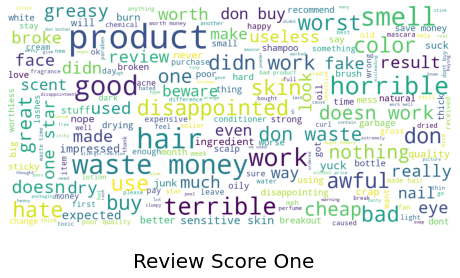

In [ ]:
show_wordcloud(cluster1["summaryClean"][0], title = "Review Score One")

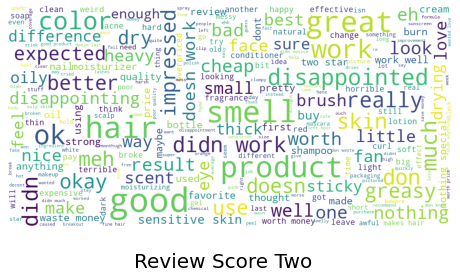

In [ ]:
show_wordcloud(cluster1["summaryClean"][1] , title = "Review Score Two")

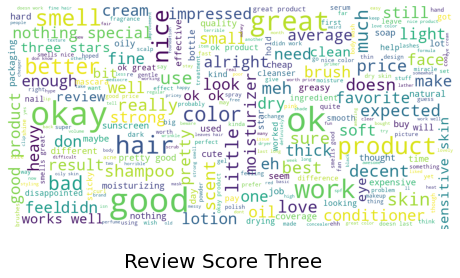

In [ ]:
show_wordcloud(cluster1["summaryClean"][2], title = "Review Score Three")

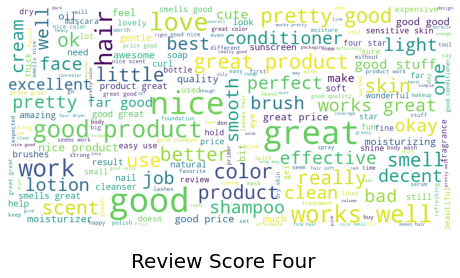

In [ ]:
show_wordcloud(cluster1["summaryClean"][3], title = "Review Score Four")

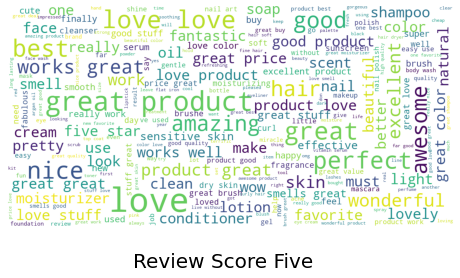

In [ ]:
show_wordcloud(cluster1["summaryClean"][4], title = "Review Score Five")